**Clustering of real data:**
- importare una serie dei prezzi reali
- scegliere un coefficiente da utilizzare come test statistico TS -> come lo scelgo?
- effettuare più clustering (almeno 100) per il medesimo path scelto: in principio il risultato potrebbe dipendere dal tipo di clustering_seed usato
- costruire un istogramma normalizzato di TS per le varie ripetizioni



**Null model generation:**

- fittare un GARCH di qualche tipo al path dei prezzi reali 
- scegliere secondo qualche criterio il miglior GARCH* per descrivere il path di prezzo
- generare molteplici (almeno 100) path di prezzo secondo GARCH*
- per ciascun path sintetico generato effettuare un clustering e calcolare TS
- costruire un istogramma normalizzato per TS

**Assesment:**
- in qualche modo stabilire se i clusters trovati con nei dati reali sono significativi rispetto a quelli trovati: poichè in tale caso avrei due popolazioni potrei utilizzare un Kolmogorov-Smirnov...


# Clustering of real data

In [1]:
import time
import numpy as np
import pandas as pd
import os
# graphycal 
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
# clustering
from w_k_means import WassersteinKMeans, w_k_means, w_lift_function
from utils.pre_processing_utils import data_par
from utils.io_utils import ensure_directory_exists
# test statistic
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
# garch generation
from arch.univariate import arch_model


def confidence_interval(x, confidence_level):
    lower_percentile = 100 * (1 - confidence_level) / 2
    upper_percentile = 100 * (1 + confidence_level) / 2

    lower_bound = np.percentile(x, lower_percentile)
    upper_bound = np.percentile(x, upper_percentile)
    
    return lower_bound, upper_bound

In [2]:
# path
path = 'IBM'

# import real data (hourly frequency)
df = pd.read_csv('real_data/' + path.lower() + '_time_series.txt')
prices = df['price'].values
t = df['time'].values
# hourly log returns
log_returns = np.diff(np.log(prices))
N = len(log_returns)

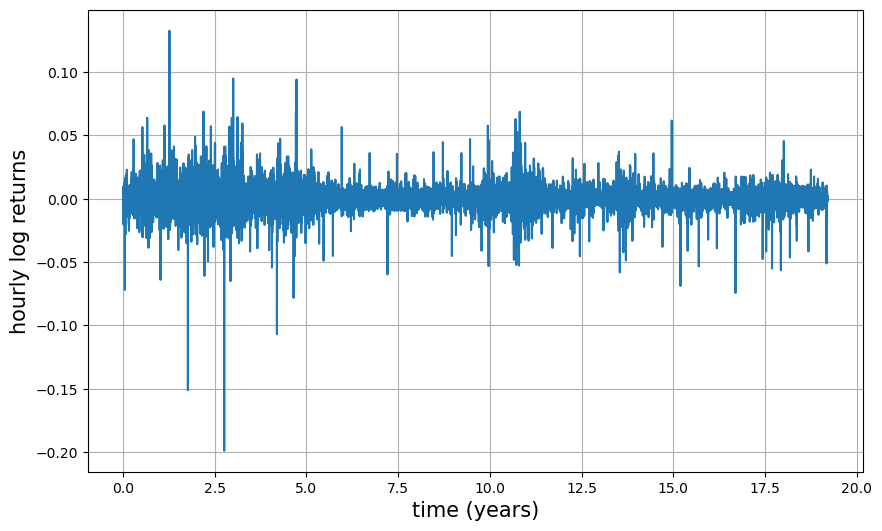

In [7]:
# # hourly percentage returns
# r = 100 * np.diff(prices) / prices[:-1]
# plt.figure()
# plt.plot(t[:-1], r)
# plt.ylabel('hourly returns')
# plt.xlabel('time (years)')
# plt.grid()

# plt.figure()
# # hourly price changes
# x = np.diff(prices)
# plt.plot(t[:-1], x)
# plt.ylabel('hourly price changes')
# plt.xlabel('time (years)')
# plt.grid()

plt.figure(figsize=(10, 6))
plt.plot(t[:-1], log_returns)
plt.ylabel('hourly log returns', size=15)
plt.xlabel('time (years)', size=15)
plt.grid()

plt.show()

silhouette score = 0.4037546231825713


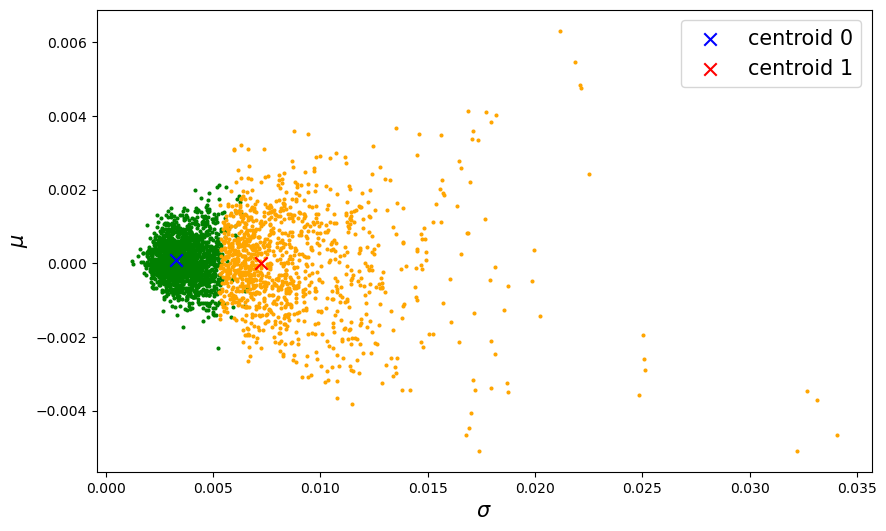

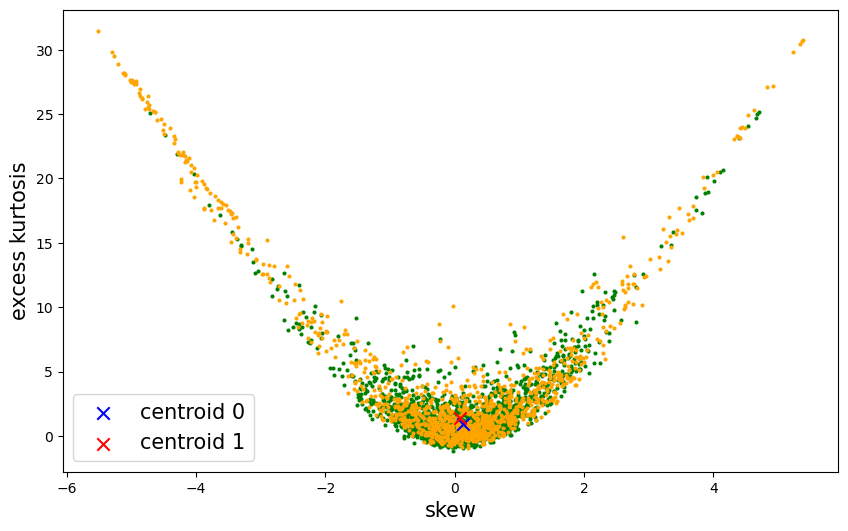

In [9]:
# clustering pre processing parameters 
h1 = 42
h2 = 31
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
# clustering parameters 
p = 1
max_iter = 600
tol = 1e-8

# pre processing
N_prime, M = data_par(N, h1, h2)

# actual variables
actual_log_returns = np.diff(np.log(prices))[: N_prime]

# clustering pre processing
X_wasserstein = w_lift_function(h1, h2, actual_log_returns, M)

# clustering implementation
wkmeans, off_regime_index, on_regime_index = w_k_means(X_wasserstein, p, max_iter, tol, seed_clustering=1)


distance_matrix = pairwise_distances(X_wasserstein, metric='minkowski', p=p) / (X_wasserstein.shape[1]**(1/p))
print(f"silhouette score = {silhouette_score(distance_matrix, wkmeans.labels_, metric='precomputed')}")

wk_mu_std_plot(X_wasserstein, wkmeans, off_regime_index, on_regime_index)

wk_kurt_skew_plot(X_wasserstein, wkmeans, off_regime_index, on_regime_index)



### silhouette score approach

- studiati valori seed da i=0 a i=299, quindi su 300 clustering_seed 2 sono risultati patologici:
- i = 164, 272; 
labellizzare mi serve per vedere nel dettaglio cosa sta succedendo quando siamo di fronte ad un silhouette score diverso dalla gran parte del campione. Quello che ho notato è che nei casi patologici vieni di fatto identificato un solo cluster. <br>
Fatto interessante: nonostante si facciano p, variare max_iter e tol, non si riesce ad impedire l'outcome del clustering sia patologico.<br>
In generale, a parte il caso patologico, si riscontrano due valori molto vicini che si alternano a seconda del seme del clusetring (con un errore relativo del 0.08 %)


In [258]:
# clustering pre processing parameters 
h1 = 63
h2 = 47
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
# clustering parameters 
p = 1
max_iter = 600
tol = 1e-8

# pre processing
N_prime, M = data_par(N, h1, h2)

# actual variables
actual_log_returns = np.diff(np.log(prices))[: N_prime]

# clustering pre processing
X_wasserstein = w_lift_function(h1, h2, actual_log_returns, M)

# number of iterations
n = 100
real_silhouette_array = np.zeros(n)

start = time.time()
for i in range(n):
    # clustering implementation
    wkmeans, off_regime_index, on_regime_index = w_k_means(X_wasserstein, p, max_iter, tol)
    # silhouette score computation
    distance_matrix = pairwise_distances(X_wasserstein, metric='minkowski', p=p) / (X_wasserstein.shape[1]**(1/p))
    real_silhouette_array[i] = silhouette_score(distance_matrix, wkmeans.labels_, metric='precomputed')
    
end = time.time() - start
print(f'execution time = {end} sec')

directory_path = f'validation_results/{path}/W_k_means/h_{h1}_{h2}/max_iter_{max_iter}_tol_{tol}/p_{p}'
ensure_directory_exists(directory_path)
file_name = f"silhouette_n_{n}.txt"
file_path = os.path.join(directory_path, file_name)
np.savetxt(file_path, real_silhouette_array)

execution time = 17.512176513671875 sec
Directory created: validation_results/IBM/W_k_means/h_63_47/max_iter_600_tol_1e-08/p_1


In [15]:
# Specifica il percorso del file
file_path = "validation_results/IBM/W_k_means/h_35_28/max_iter_600_tol_1e-08/p_1/silhouette_n_100.txt"

# Caricamento del file come array NumPy
try:
    # Per file semplici (valori separati da spazi, tab o virgole)
    real_score = np.loadtxt(file_path)
    
except Exception as e:
    print(f"Errore durante il caricamento del file: {e}")

mean value = 0.3902543917694528
95% CI = (0.3873902763533741, 0.38769592274312165)


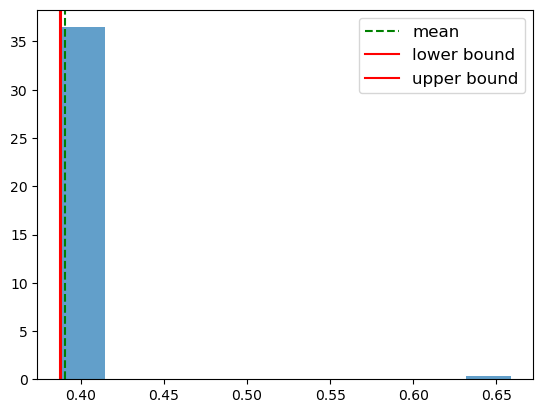

In [16]:
confidence_level = 0.95
real_lower_bound, real_upper_bound = confidence_interval(real_score, confidence_level)
print(f'mean value = {np.mean(real_score)}')
print(f'{int(100*confidence_level)}% CI = {(real_lower_bound, real_upper_bound)}')
plt.hist(real_score, bins=int(np.sqrt(len(real_score))), density=True, alpha=0.7)
plt.axvline(x=np.mean(real_score), color='green', linestyle='--', label='mean')
plt.axvline(x=real_lower_bound, color='red', linestyle='-', label='lower bound')
plt.axvline(x=real_upper_bound, color='red', linestyle='-', label='upper bound')
plt.legend(fontsize=12)
plt.show()

mean value = 0.3875415558796127
95% CI = (0.3873902763533741, 0.38769592274312165)


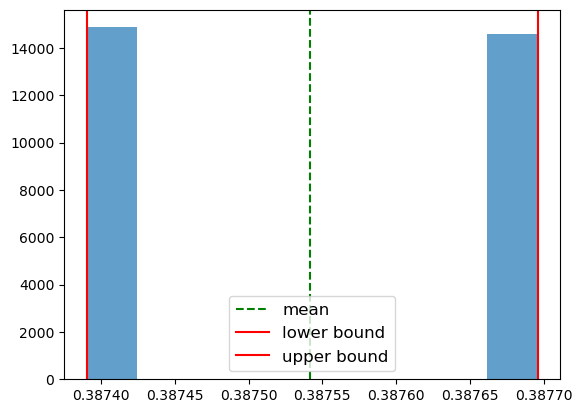

In [17]:
# removing out-liers
real_s = real_score[real_score < 0.6]
confidence_level = 0.95
real_lower_bound, real_upper_bound = confidence_interval(real_s, confidence_level)
print(f'mean value = {np.mean(real_s)}')
print(f'{int(100*confidence_level)}% CI = {(real_lower_bound, real_upper_bound)}')
plt.hist(real_s, bins=int(np.sqrt(len(real_s))), density=True, alpha=0.7)
plt.axvline(x=np.mean(real_s), color='green', linestyle='--', label='mean')
plt.axvline(x=real_lower_bound, color='red', linestyle='-', label='lower bound')
plt.axvline(x=real_upper_bound, color='red', linestyle='-', label='upper bound')
plt.legend(fontsize=12)
plt.show()

In [18]:
# percentage error
100*(np.max(real_s)-np.min(real_s))/np.min(real_s)

0.07889882849531109

# Null model generation

In [47]:
def wk_mu_std_plot(X, wkmeans, off_regime_index, on_regime_index):

    # scatter plot of empirical cdf
    plt.figure(figsize=(10, 6))
    point_size = 15
    plt.scatter(
        np.std(X[wkmeans.labels_ == off_regime_index], axis=1),
        np.mean(X[wkmeans.labels_ == off_regime_index], axis=1),
        marker='.', color='green', alpha=1, s=point_size)
    plt.scatter(
        np.std(X[wkmeans.labels_ == on_regime_index], axis=1),
        np.mean(X[wkmeans.labels_ == on_regime_index], axis=1),  
        marker='.', color='orange', alpha=1, s=point_size)
    # scatter plot of centroids
    plt.scatter(np.std(wkmeans.cluster_centers_, axis=1)[off_regime_index],
                np.mean(wkmeans.cluster_centers_, axis=1)[off_regime_index],
                color='blue', marker='x', label='centroid 0', s=80)
    plt.scatter(np.std(wkmeans.cluster_centers_, axis=1)[on_regime_index],
                np.mean(wkmeans.cluster_centers_, axis=1)[on_regime_index],
                color='red', marker='x', label='centroid 1', s=80)

    plt.xlabel(f'$\sigma$', size=15)
    plt.ylabel(f'$\mu$', size=15)
    plt.legend(fontsize=15)
#     plt.savefig('garch_w_1_mu_std.pdf')
    plt.show()

def wk_kurt_skew_plot(X, wkmeans, off_regime_index, on_regime_index):
    # scatter plot of empirical cdf
    plt.figure(figsize=(10, 6))
    point_size = 15
    plt.scatter(
        skew(X[wkmeans.labels_ == off_regime_index], axis=1),
        kurtosis(X[wkmeans.labels_ == off_regime_index], axis=1),
        marker='.', color='green', alpha=1, s=point_size)
    plt.scatter(
        skew(X[wkmeans.labels_ == on_regime_index], axis=1),
        kurtosis(X[wkmeans.labels_ == on_regime_index], axis=1),  
        marker='.', color='orange', alpha=1, s=point_size)
    # scatter plot of centroids
    plt.scatter(skew(wkmeans.cluster_centers_, axis=1)[off_regime_index],
                kurtosis(wkmeans.cluster_centers_, axis=1)[off_regime_index],
                color='blue', marker='x', label='centroid 0', s=80)
    plt.scatter(skew(wkmeans.cluster_centers_, axis=1)[on_regime_index],
                kurtosis(wkmeans.cluster_centers_, axis=1)[on_regime_index],
                color='red', marker='x', label='centroid 1', s=80)

    plt.xlabel(f'skew', size=15)
    plt.ylabel(f'excess kurtosis', size=15)
    plt.legend(fontsize=15)
#     plt.savefig('garch_w_1_kurt_skew.pdf')
    plt.show()

# price_returns_plot(t, prices)
# wk_mu_std_plot(X_wasserstein, wkmeans, off_regime_index, on_regime_index)
# wk_kurt_skew_plot(X_wasserstein, wkmeans, off_regime_index, on_regime_index)

mean = 6.180627498959349e-05
std = 0.015606073827472982


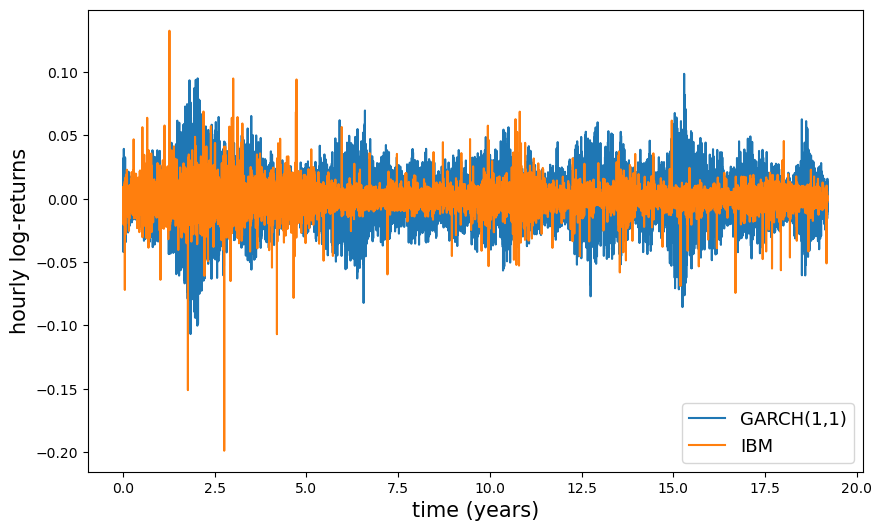

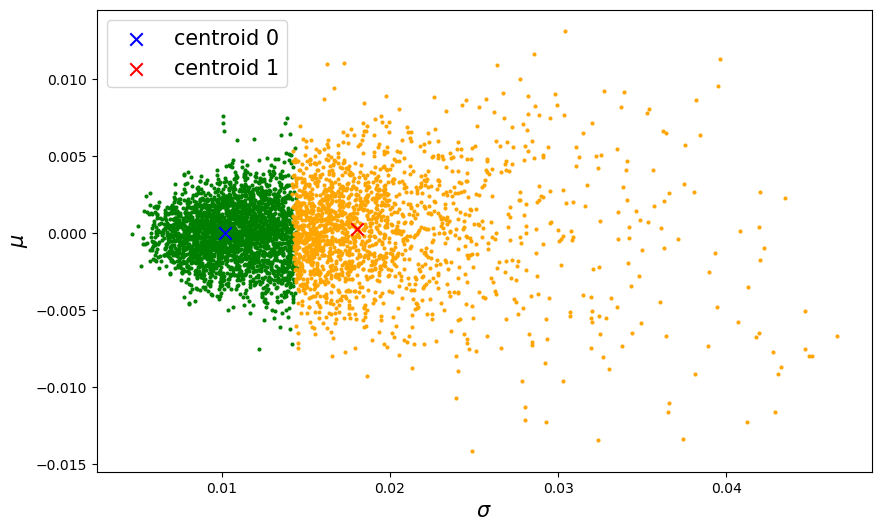

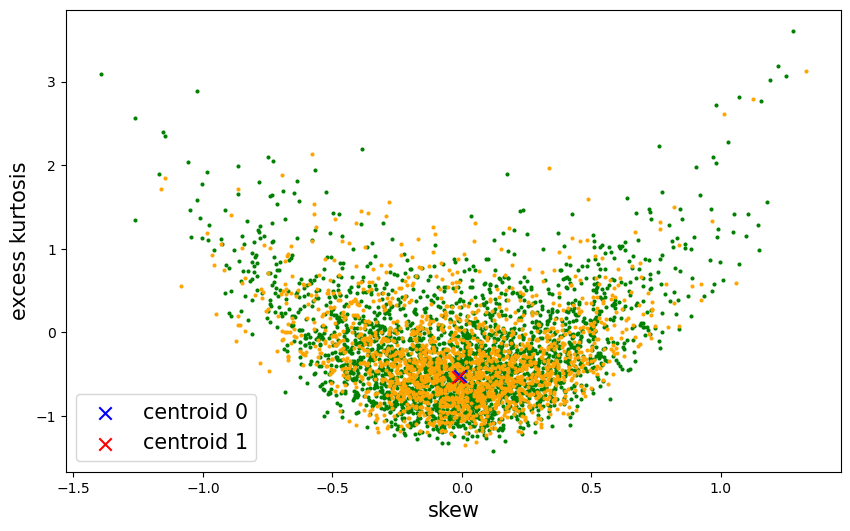

silhouette score = 0.3825526274303825


In [48]:
# fit GARCH to real data
dist = 'normal'
am = arch_model(log_returns * 100, dist=dist)
garch_fit = am.fit(disp='off')
# GARCH generation
log_returns_garch = am.simulate(garch_fit.params, nobs=N)['data'].values
log_returns_garch /=100
print(f'mean = {np.mean(log_returns_garch)}\nstd = {np.std(log_returns_garch)}')

# plot log returns GARCH vs REAL
plt.figure(figsize=(10, 6))
plt.plot(t[:-1], log_returns_garch, label=f'GARCH(1,1)')
plt.plot(t[:-1], log_returns, label=f'{path}')
plt.ylabel('hourly log-returns', size=15)
plt.xlabel('time (years)', size=15)
plt.legend(fontsize=13)
#plt.savefig('garch_ibm_returns.pdf')
plt.show()


# clustering pre processing parameters 
h1 = 35
h2 = 28

# clustering parameters 
p = 1
max_iter = 600
tol = 1e-8

# pre processing
N_prime, M = data_par(N, h1, h2)

# actual variable
actual_log_returns_garch = log_returns_garch[: N_prime]

# clustering pre processing
X_wasserstein = w_lift_function(h1, h2, actual_log_returns_garch, M)

# clustering implementation
wkmeans, off_regime_index, on_regime_index = w_k_means(X_wasserstein, p, max_iter, tol)

wk_mu_std_plot(X_wasserstein, wkmeans, off_regime_index, on_regime_index)
wk_kurt_skew_plot(X_wasserstein, wkmeans, off_regime_index, on_regime_index)
# silhouette score computation
distance_matrix = pairwise_distances(X_wasserstein, metric='minkowski', p=p) / (X_wasserstein.shape[1]**(1/p))
print(f"silhouette score = {silhouette_score(distance_matrix, wkmeans.labels_, metric='precomputed')}")

In [259]:
# fit GARCH to real data
dist = 'normal'
am = arch_model(log_returns * 100, dist=dist)
garch_fit = am.fit(disp='off')

# clustering pre processing parameters 
h1 = 63
h2 = 47

# clustering parameters 
p = 1
max_iter = 600
tol = 1e-8

# pre processing
N_prime, M = data_par(N, h1, h2)


n_garch = 1000
silhouette_array = np.zeros(n_garch)

start = time.time()
for i in range(n_garch):
    # path generation
    log_returns_garch = am.simulate(garch_fit.params, nobs=N)['data'].values
    log_returns_garch /=100
    
    # actual variable
    actual_log_returns_garch = log_returns_garch[: N_prime]

    # clustering pre processing
    X_wasserstein = w_lift_function(h1, h2, actual_log_returns_garch, M)
    
    # clustering implementation
    wkmeans, off_regime_index, on_regime_index = w_k_means(X_wasserstein, p, max_iter, tol)
    
    # silhouette score computation
    distance_matrix = pairwise_distances(X_wasserstein, metric='minkowski', p=p) / (X_wasserstein.shape[1]**(1/p))
    silhouette_array[i] = silhouette_score(distance_matrix, wkmeans.labels_, metric='precomputed')
    
end = time.time() - start
print(f'execution time = {end} sec')

directory_path = f'validation_results/{path}/W_k_means/h_{h1}_{h2}/max_iter_{max_iter}_tol_{tol}/p_{p}'
ensure_directory_exists(directory_path)
file_name = f"silhouette_garch_{dist}_n_{n_garch}.txt"
file_path = os.path.join(directory_path, file_name)
np.savetxt(file_path, silhouette_array)

execution time = 308.7263288497925 sec
Directory validation_results/IBM/W_k_means/h_63_47/max_iter_600_tol_1e-08/p_1 already existed. You might have overwritten the data!


mean value = 0.4891111936240708
95% CI = (0.35176944373650443, 0.7710028411958982)


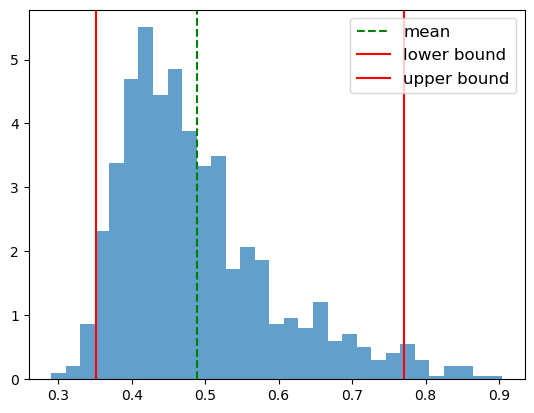

In [8]:
# Specifica il percorso del file
file_path = "validation_results/IBM/W_k_means/h_35_28/max_iter_600_tol_1e-08/p_1/silhouette_garch_normal_n_1000.txt"

# Caricamento del file come array NumPy
try:
    # Per file semplici (valori separati da spazi, tab o virgole)
    garch_score = np.loadtxt(file_path)
    
except Exception as e:
    print(f"Errore durante il caricamento del file: {e}")

confidence_level = 0.95
garch_lower_bound, garch_upper_bound = confidence_interval(garch_score, confidence_level)
print(f'mean value = {np.mean(garch_score)}')
print(f'{int(100*confidence_level)}% CI = {(garch_lower_bound, garch_upper_bound)}')
plt.hist(garch_score, bins=int(np.sqrt(len(garch_score))), density=True, alpha=0.7)
plt.axvline(x=np.mean(garch_score), color='green', linestyle='--', label='mean')
plt.axvline(x=garch_lower_bound, color='red', linestyle='-', label='lower bound')
plt.axvline(x=garch_upper_bound, color='red', linestyle='-', label='upper bound')
plt.legend(fontsize=12)
plt.show()

In [ ]:
# # removing out-liers
# garch_s = garch_score[garch_score < 0.6]
# confidence_level = 0.95
# garch_lower_bound, garch_upper_bound = confidence_interval(garch_s, confidence_level)
# print(f'mean value = {np.mean(garch_s)}')
# print(f'{int(100*confidence_level)}% CI = {(garch_lower_bound, garch_upper_bound)}')
# plt.hist(garch_s, bins=int(np.sqrt(len(garch_s))), density=True, alpha=0.7)
# plt.axvline(x=np.mean(garch_s), color='green', linestyle='--', label='mean')
# plt.axvline(x=garch_lower_bound, color='red', linestyle='-', label='lower bound')
# plt.axvline(x=garch_upper_bound, color='red', linestyle='-', label='upper bound')
# plt.legend(fontsize=12)
# plt.show()

# Assessment

In [7]:
def confidence_bound(x, confidence_level):
    upper_percentile = 100 * confidence_level
    upper_bound = np.percentile(x, upper_percentile)
    
    return upper_bound

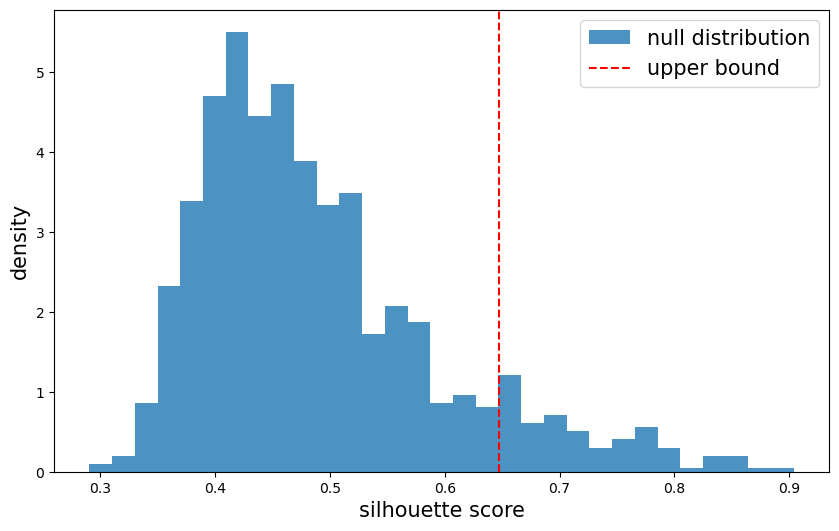

In [29]:
# Set the confidence level !
confidence_level = 0.9
n = len(garch_score)
plt.figure(figsize=(10, 6))
upper_bound = confidence_bound(garch_score, confidence_level)
plt.hist(garch_score, bins=int(np.sqrt(n)), density=True, alpha=0.8, label='null distribution')
plt.axvline(x=upper_bound, color='red', linestyle='--', label='upper bound')
plt.xlabel('silhouette score', size=15)
plt.ylabel('density', size=15)
plt.legend(fontsize=15)
#plt.savefig('garch_silhouette_hist.pdf')
plt.show()

In [19]:
real_silhouette_array = real_s
silhouette_array = garch_score
n = len(silhouette_array)

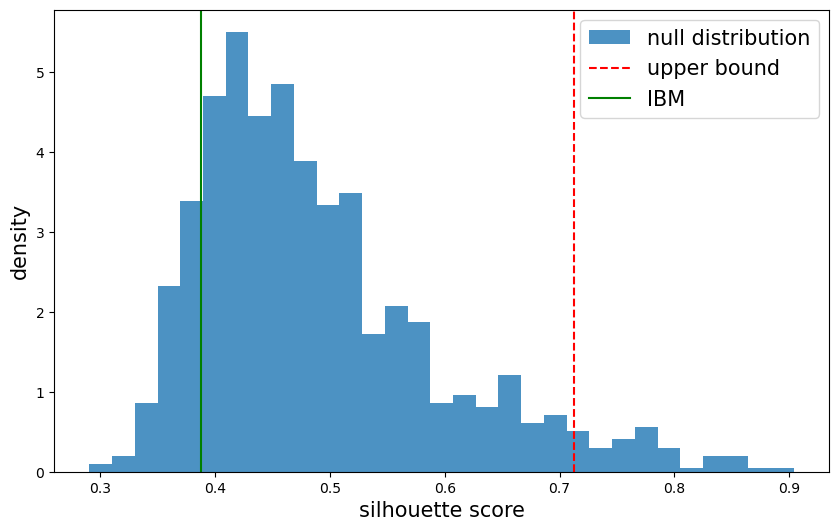

In [31]:
# Set the confidence level !
confidence_level = 0.95

upper_bound = confidence_bound(silhouette_array, confidence_level)
dec = 3
plt.figure(figsize=(10, 6))
plt.hist(silhouette_array, bins=int(np.sqrt(n)), density=True, alpha=0.8, label='null distribution')
plt.axvline(x=upper_bound, color='red', linestyle='--', label='upper bound')
plt.axvline(x=np.mean(real_silhouette_array), color='green', linestyle='-', label=f'{path}')
plt.xlabel('silhouette score', size=15)
plt.ylabel('density', size=15)
plt.legend(fontsize=15)
plt.savefig('ibm_garch_silhouette_hist.pdf')
plt.show()

## dependences from h1 and h2

In [ ]:
# Specifica il percorso del file
file_path = "validation_results/IBM/W_k_means/h_35_28/max_iter_600_tol_1e-08/p_2/silhouette_garch_normal_n_1000.txt"

# Caricamento del file come array NumPy
try:
    # Per file semplici (valori separati da spazi, tab o virgole)
    s = np.loadtxt(file_path)
    
except Exception as e:
    print(f"Errore durante il caricamento del file: {e}")

In [ ]:
# with overlapping h2=int(h1*3/4)
x = np.array([7, 14, 21, 28, 35, 42, 49, 56, 63])

y = np.array([])

yerr = np.array([[],  
                 []])

yerr[0] = y - yerr[0] 
yerr[1] = yerr[1] - y

#  scatter plot creation with error barr 
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-')
plt.axvline(x=35, color='green', linestyle='--', label='1 w')
plt.axvline(x=35*4, color='orange', linestyle='--', label='1 m')
plt.axvline(x=882, color='red', linestyle='--', label='6 m')
plt.axvline(x=35*4*12, color='purple', linestyle='--', label='1 y')
plt.xlabel(f'$h_{1}$', size=14)
plt.ylabel('RONS (%)', size=14)
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()